In [1]:
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 24}
plt.rc('font', **font)
from scipy.signal import argrelmin
from scipy.signal import argrelmax
from scipy.signal import savgol_filter

In [2]:
def localize(raw_ext):
    list2=[]
    for i, ref in enumerate(raw_ext):
        close = np.abs(raw_ext - ref) < 50
        if np.sum(close) > 0 and raw_ext[close].tolist() not in list2:
            list2.append(raw_ext[close].tolist())
    
    final=[]
    for l in list2:
        final.append(int(np.average(l)))
    return np.array(final)

In [3]:
def find_extrema(l):
    l1=localize(l)
    l2=localize(l1)
    while len(l1)!=len(l2):
        l1=localize(l2)
        l2=localize(l1)
    return l2

In [4]:
def plot_savgol(cost,sg,extrema,i,xmin,xmax):
    plt.plot(cost,alpha=0.5,label='original rms')
    plt.plot(sg,alpha=0.8,label='Savitzky-Golay')
    plt.scatter(extrema,sg[extrema],c='r',s=100,zorder=3,label='extrema')
    plt.axvline(i, color='k', linestyle='--')
    plt.xlabel('iterations')
    plt.ylabel('rms')
    plt.legend()
    plt.xlim(xmin,xmax)

In [28]:
def plot_rays(optic,raymatrix,exp_f,zoom=False,norm=False):
    #first plot the optic:
    opt_r=optic[0] if not norm else optic[0]/lambda0
    opt_z=optic[1] if not norm else optic[1]/lambda0
    plt.plot(opt_z,opt_r,'k',opt_z,-1*opt_r,'k')
    exp_freq=exp_f if not norm else exp_f/lambda0
    plt.axvline(x=exp_freq, color='k', linestyle='--')
    #Then plot the rays:
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.RdYlGn(np.linspace(0, 1, 2*len(raymatrix)))))
    for ray in raymatrix:
        ray_r=ray[0:2] if not norm else ray[0:2]/lambda0
        ray_z=ray[2:] if not norm else ray[2:]/lambda0
        plt.plot(ray_z,ray_r,ray_z,-1*ray_r,alpha=0.75)

    xl='z (m)' 
    yl='r (m)' 
    plt.xlabel(xl)
    plt.ylabel(yl)
    xlimit = (-0.01,exp_f+0.01) if not zoom else (exp_f-0.005,exp_f)
    plt.xlim(xlimit)
    r_max=max(opt_r)+0.001
    ylimit=(-r_max,r_max) if not zoom else (-0.0005,0.0005)
    plt.ylim((-r_max,r_max))

In [7]:
def calc_bw(lambda0,diam,dec=6):
    ang_res= 1.22*lambda0/diam # The bin width is set as the minimum resolution 
    return np.around(ang_res,dec) 

In [24]:
def plot_hist(after,binwidth):
    n=len(after)
    #make k odd so that we have even number of bin below and above the expected focal value
    k=int(np.ceil(np.log2(n)))+1
    if k%2==0:
        k+=1
    bin_low=bw*(-0.5*k)
    bin_high=bw*(-0.5*k)

    cor_bins=np.linspace(bin_low,bin_high,k+1)
    counts,bins=np.histogram(after,cor_bins)
    plt.stairs(counts,bins)
    plt.xlabel('r (m)')
    plt.ylabel('count')
    

In [26]:
def plot_range(cost,sg,extrema,optic,raymatrix,exp_f,after,binwidth,i,xmin,xmax):
    
    plt.figure(figsize=(16,9))
    plt.subplot(221)
    plot_savgol(cost,sg,extrema,i,xmin,xmax)
    
    plt.subplot(222)
    plot_rays(optic,raymatrix,exp_f)

    plt.subplot(223)
    plot_hist(after,binwidth)
    
    plt.subplot(224)
    plot_rays(optic,raymatrix,exp_f,zoom=True)
    
    plt.tight_layout()
    plt.show()
    #plt.savefig('scrub_plots'+title+'step %i')

In [10]:
paths=[ f.path for f in os.scandir("/Users/gracekim/flying_focus/rdylgn/") if f.is_dir() ]
paths.sort()
titles=[x.split('/')[-1] for x in paths]

In [11]:
p=paths[0]
t=titles[0]
xmin=10
xmax=20

In [12]:
calc_bw(1.054e-6,0.075)

1.7e-05

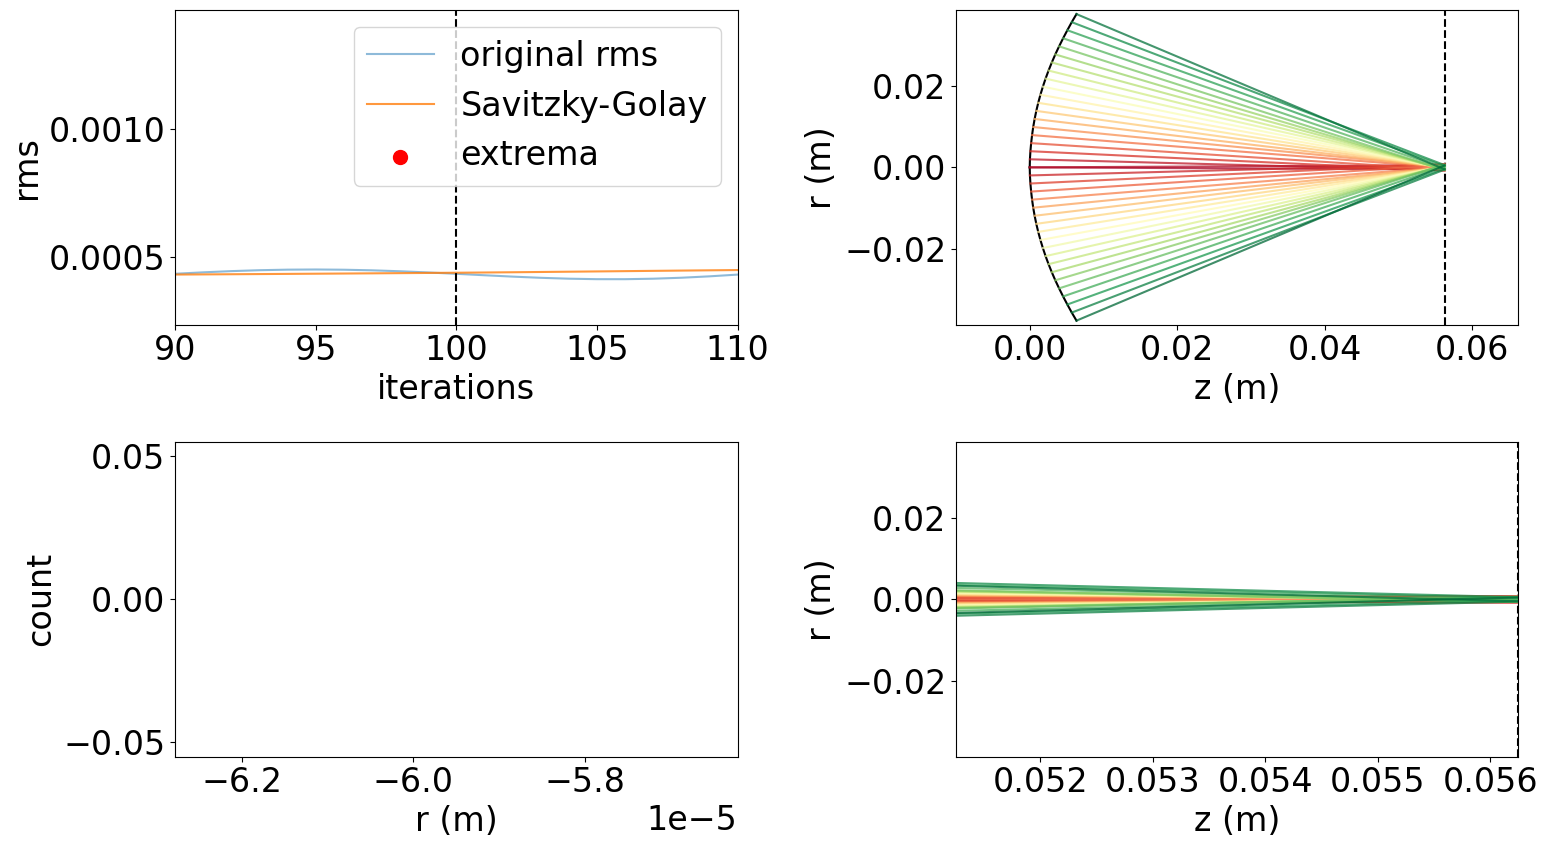

In [30]:
os.chdir(p)
# os.system('mkdir scrub_gif')
# os.system('mkdir scrub_plots')
ext=np.genfromtxt(t+"_ext.csv")
cost=np.genfromtxt(t+'_cost.csv')
sg=savgol_filter(cost,201,3)
o_r=np.genfromtxt(t+'_o_r.csv')
o_z=np.genfromtxt(t+'_o_z.csv')
aft=np.genfromtxt(t+'_after.csv')
ld=np.genfromtxt(t+"_rm.csv")
raym=ld.reshape(ld.shape[0],ld.shape[1]//4,4)

i=100
optic=[o_r,o_z[i]]
after=aft[i]
bw=calc_bw(1.054e-6,0.075)
xmin=90
xmax=110
rm=raym[i]

plot_range(cost,sg,ext.astype(int),optic,rm,0.05625,after,bw,i,xmin,xmax)